In [2]:


import numpy as np
from tqdm import tqdm
import random
import gym
from gym.wrappers import RecordVideo
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML

In [3]:
#Setting up the environment
env=gym.make("Taxi-v3",render_mode='ansi')

env.reset()
#Current State
#state is in the form of [taxi_row,taxi_col,passenger_location,destination]
# passenger locations        # Destinations
# 0: R(ed)                   # 0: R(ed) 
# 1: G(reen)                 # 1: G(reen)
# 2: Y(ellow)                # 2: Y(ellow)
# 3: B(lue)                  # 3: B(lue)
# 4: in taxi

# 0,0 is top left

print(env.s)
print("decoded state= ",list(env.decode(env.s)))

action = ["south", "north", "east", "west",'pickup','drop']
#correspond to [0,1,2,3,4,5] that's actually passed to the environment

print ("Number of actions that an agent can take:", env.action_space)

# Example Transitions
rnd_action = random.randint(0, 5)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal,truncated, t_prob, = env.step(rnd_action)

print ("Transition probability:", t_prob) # action_mask tell us which actions will result in a change of state
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)
env.render()

421
decoded state=  [4, 1, 0, 1]
Number of actions that an agent can take: Discrete(6)
Action taken: east
Transition probability: {'prob': 1.0, 'action_mask': array([0, 1, 0, 1, 0, 0], dtype=int8)}
Next state: 441
Reward recieved: -1
Terminal state: False


C:\Users\Shobhith Vadlamudi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


'+---------+\n|\x1bR\x1b: | : :\x1bG\x1b|\n| : | : : |\n| : : : : |\n| | : | : |\n|Y| :\x1b \x1b|B: |\n+---------+\n  (East)\n'

In [4]:
def egreedy_policy(Q,state,eps):
    if np.random.rand() < eps:
        action = np.random.randint(0,6)  # Explore action space
    else:
        action = np.argmax(Q[state])  # Exploit learned values
    return action

In [5]:
q_values_SMDP = np.zeros((500,6))
update_freq=np.zeros((500,6))
gamma = 0.9
alpha=0.1
epsilon=0.1
decay=0.99
eps_min=0.01
episode_rewards = []
for _ in tqdm(range(10000)):
    state,_ = env.reset()   
    total_reward = 0

    done = False

    # While episode is not over
    while not done :
        
        # Choose action        
        action = egreedy_policy(q_values_SMDP, state,epsilon)
        epsilon=max(eps_min,epsilon*decay)

        # Checking if primitive action
        if action < 6:
            # Perform regular Q-Learning update for state-action pair
            next_state, reward,done,_,_ = env.step(action)
            q_values_SMDP[state][action] += alpha * (reward + gamma * np.max(q_values_SMDP[next_state]) - q_values_SMDP[state][action])
            update_freq[state][action]+=1
            total_reward += reward
            state=next_state
    episode_rewards.append(total_reward)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:04<00:00, 2046.04it/s]


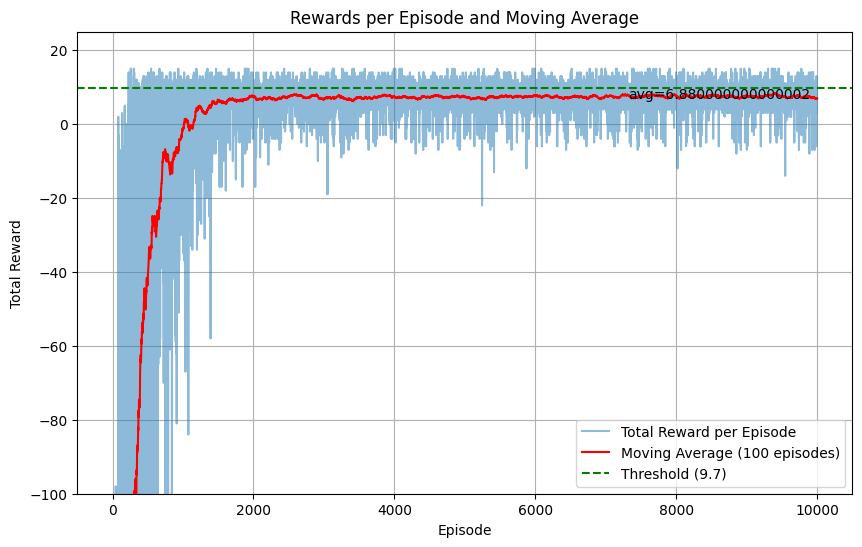

In [10]:
moving_avg = np.convolve(episode_rewards, np.ones(100)/100, mode='valid')

# Visualize the rewards per episode and the moving average
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards, label='Total Reward per Episode', alpha=0.5)
plt.plot(range(100, len(episode_rewards)+1), moving_avg, color='red', label='Moving Average (100 episodes)')
plt.axhline(y=9.7, color='green', linestyle='--', label='Threshold (9.7)')
plt.title('Rewards per Episode and Moving Average')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.ylim(-100, 25)
plt.text(len(moving_avg) - 1,moving_avg[-1] , f'avg={moving_avg[-1]}', ha='right')
plt.show()

In [7]:
print(moving_avg[-1])

6.880000000000002


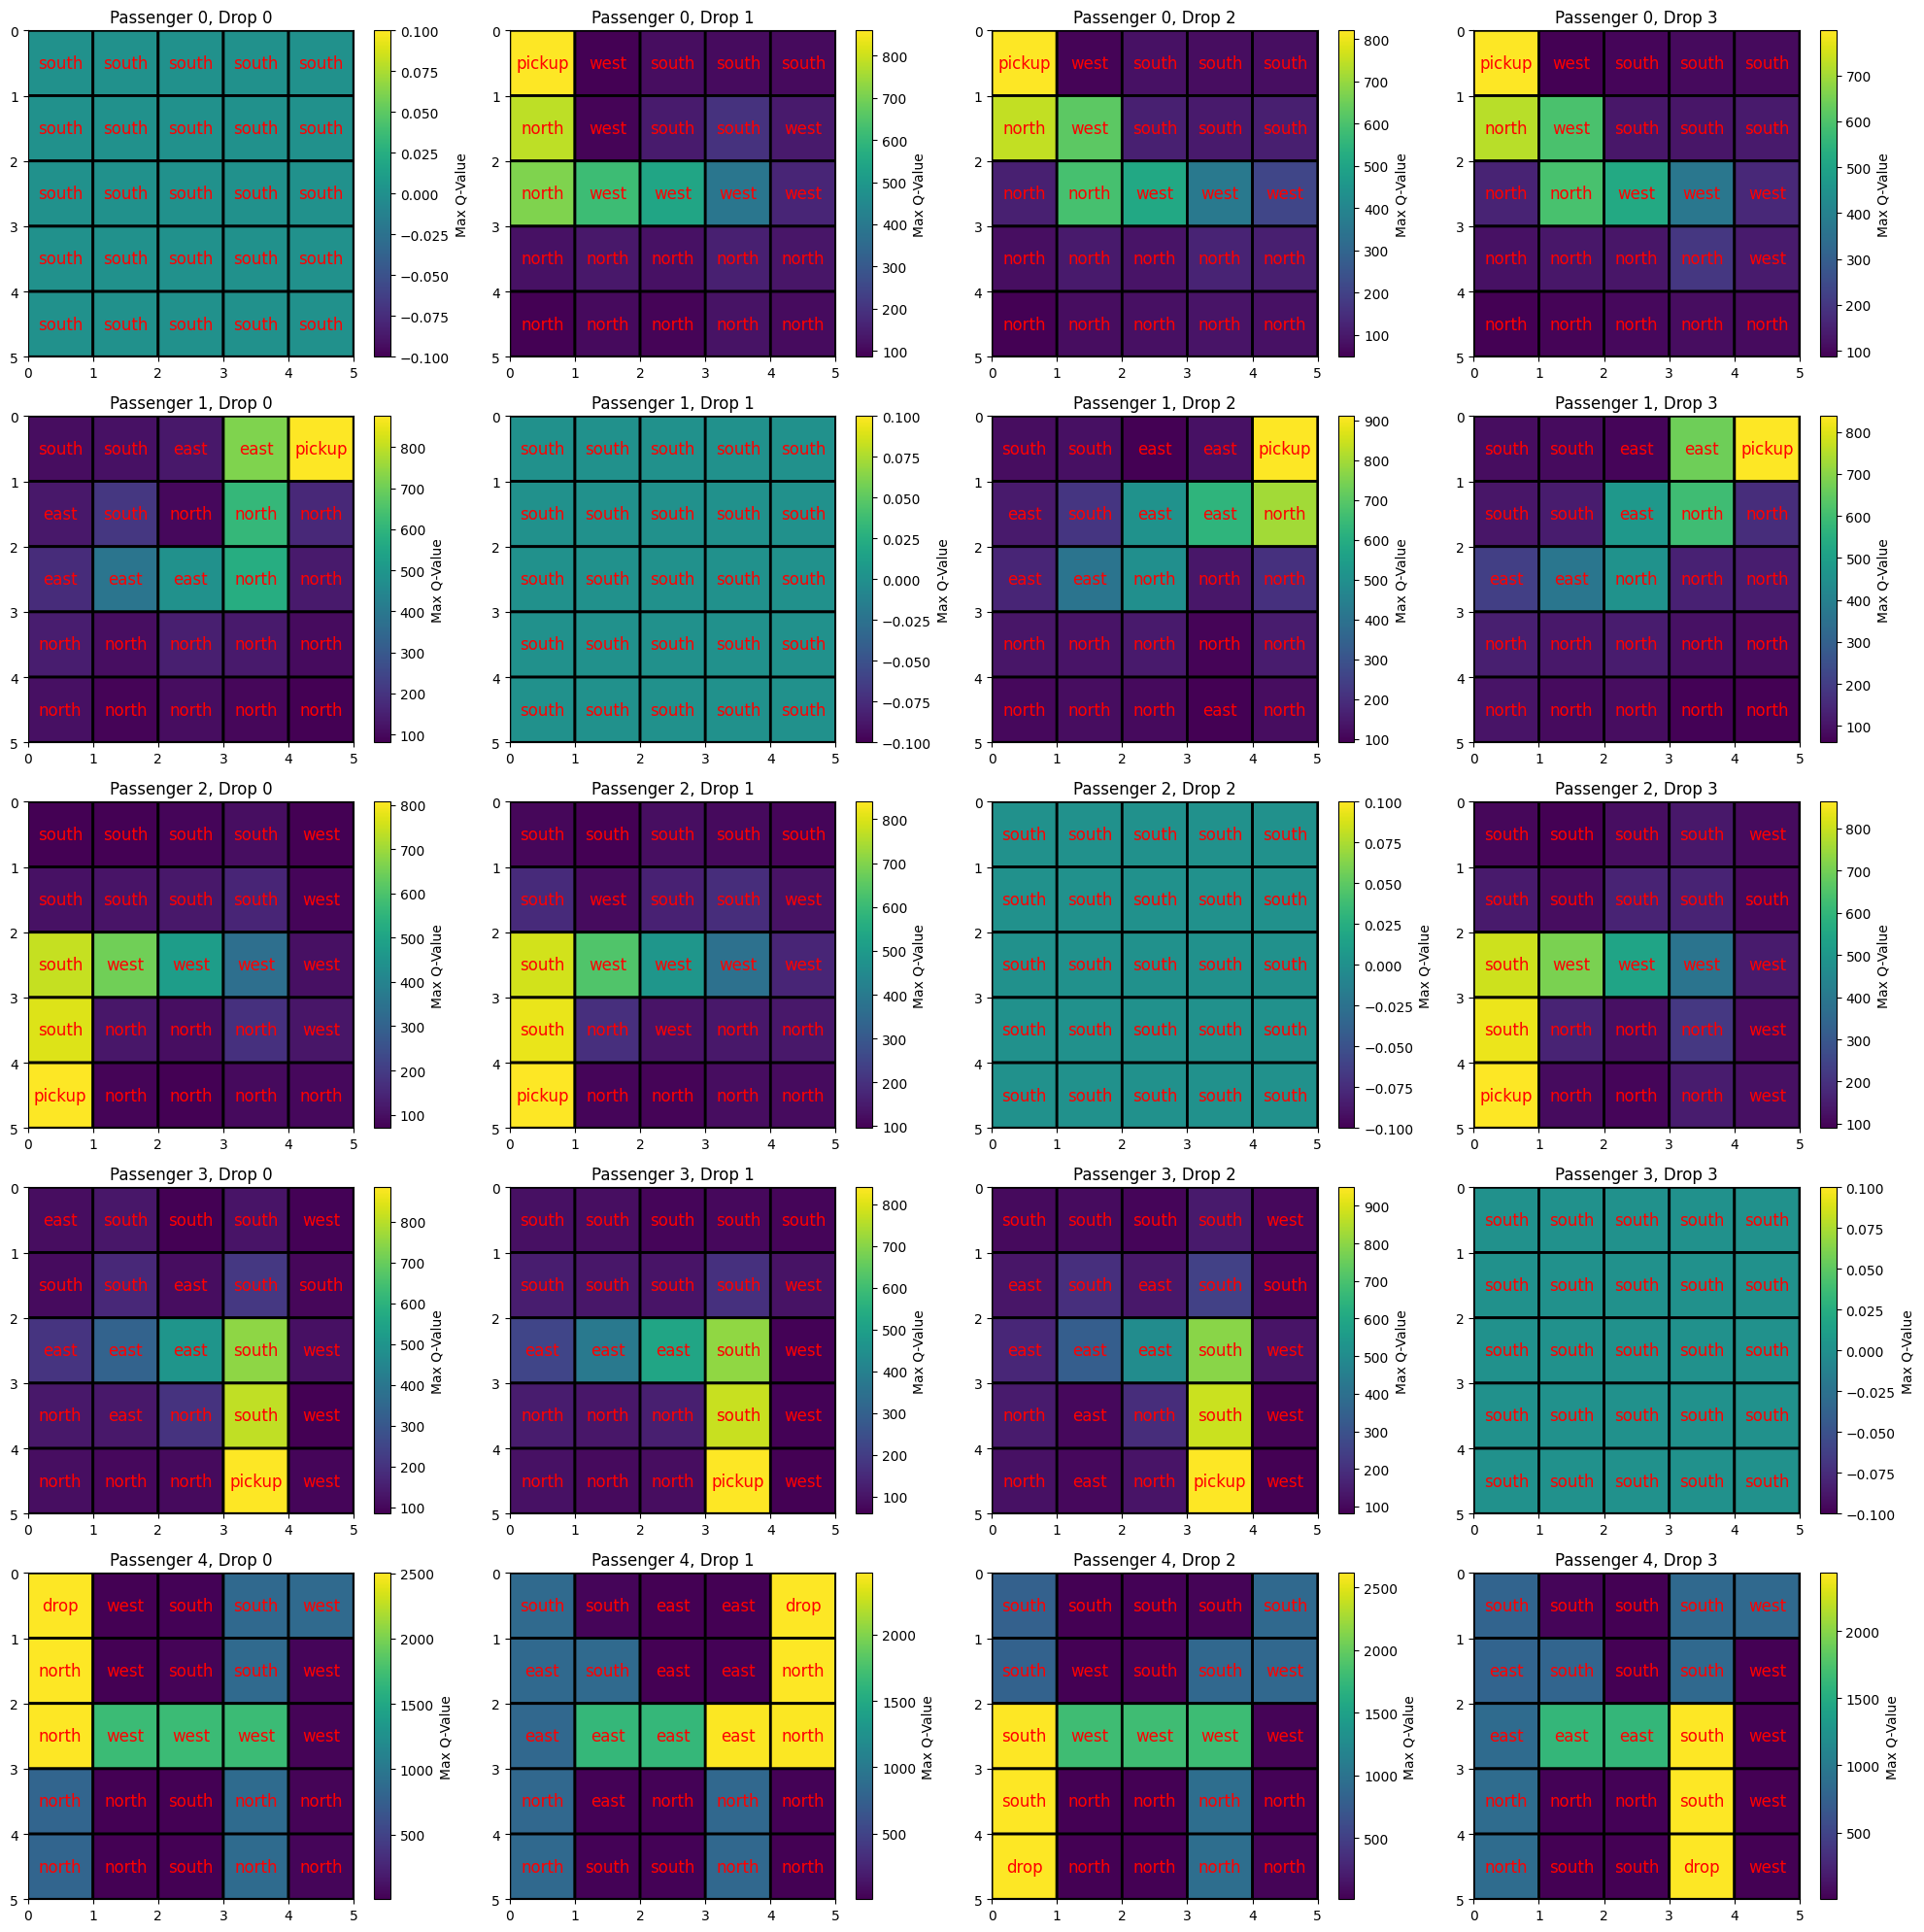

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_SMDP_Q(q_values):
    actions = ["south", "north", "east", "west", 'pickup', 'drop', 'R', 'G', 'B', "Y"]
    fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))

    for p in range(5):
        for d in range(4):
            Q = np.zeros((5, 5, 6))
            for r in range(5):
                for c in range(5):
                    state_num = 100 * r + 20 * c + 4 * p + d
                    Q[r, c] = q_values[state_num]

            ax = axes[p, d]
            ax.set_title(f"Passenger {p}, Drop {d}")
            pcm = ax.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
            for r in range(5):
                for c in range(5):
                    state_num = 100 * r + 20 * c + 4 * p + d
                    anno = actions[np.argmax(Q[r, c])]
                    ax.text(c + 0.5, r + 0.5, anno, ha='center', va='center', color='red', size='large')
            ax.invert_yaxis()

            # Add color bar for each subplot
            cbar = fig.colorbar(pcm, ax=ax, orientation='vertical')
            cbar.set_label('Max Q-Value')

    plt.tight_layout()
    plt.show()


visualize_SMDP_Q(update_freq)
